In [1]:
import sys
sys.path.append("/home/ubuntu/roaddetection/")

In [2]:
#%load_ext autoreload
#%autoreload 2

from src.models.data import *
from src.models.metrics_img import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

%matplotlib inline

Using TensorFlow backend.


In [4]:
import os, shutil

original_dataset_dir = "../../data/train"

dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

In [5]:
for directory in dirs:
    if not os.path.exists(directory):
       os.mkdir(directory)
    
fnames = ["20180419_074324_1_0c43_3B_{0:04d}.tif".format(i) for i in range(70,110)]
for fname in fnames:
    for file_type in ["sat", "map", "sat_rgb"]:
        src = os.path.join(train_dir, file_type, fname)
        dest = os.path.join(validation_dir, file_type, fname)
        shutil.move(src, dest)

In [5]:
for directory in dirs:
    for file_type in ["sat", "map", "sat_rgb"]:
        target = os.path.join(directory, file_type)
        print(target, ":", len(os.listdir(target)))
    
print("Done.")

../../data/train/sat : 284
../../data/train/map : 284
../../data/train/sat_rgb : 284
../../data/validate/sat : 40
../../data/validate/map : 40
../../data/validate/sat_rgb : 40
../../data/test/sat : 110
../../data/test/map : 110
../../data/test/sat_rgb : 110
Done.


In [6]:
data_gen_args = dict(
                    data_format="channels_last",
                    horizontal_flip=True,
                    vertical_flip=True
 )
train_generator = trainGenerator(5,'../../data/train','sat','map',
                        data_gen_args,save_to_dir = None,image_color_mode="rgba", target_size=(512,512))

In [7]:
validation_generator= trainGenerator(5,'../../data/validate','sat','map',
                        data_gen_args,save_to_dir = None,image_color_mode="rgba", target_size=(512,512))

In [8]:
def get_fcn_vgg16_32s(input_size, n_classes, pretrained_weights=None):
    inputs = Input(input_size)

    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(512, (2, 2), activation='relu', padding="same")(x)
    
    x = Conv2DTranspose(n_classes, kernel_size=(64, 64), strides=(8, 8), activation='linear', padding='same')(x)
   
    model = Model(input=inputs, output=x)
        
    model.compile(optimizer=SGD(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', IoU_binary])
    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [9]:
model = get_fcn_vgg16_32s((512, 512, 4),1, pretrained_weights="../../models/fcnn_29_08_22_00.hdf5")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 4)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 4)       16        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      2368      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 128, 128, 256)     295168    
__________

In [10]:
model_checkpoint = ModelCheckpoint('../../models/fcnn_29_08_22_00.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    callbacks=[model_checkpoint],
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
Found 284 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 284 images belonging to 1 classes.
100/100 [==============================] - 62s 617ms/step - loss: 0.1353 - acc: 0.9682 - IoU_binary: 0.0000e+00 - val_loss: 0.0740 - val_acc: 0.9867 - val_IoU_binary: 0.0000e+00

Epoch 00001: loss improved from inf to 0.13532, saving model to ../../models/fcnn_29_08_22_00.hdf5
Epoch 2/10
100/100 [==============================] - 51s 505ms/step - loss: 0.1348 - acc: 0.9683 - IoU_binary: 0.0000e+00 - val_loss: 0.0735 - val_acc: 0.9867 - val_IoU_binary: 0.0000e+00

Epoch 00002: loss improved from 0.13532 to 0.13498, saving model to ../../models/fcnn_29_08_22_00.hdf5
Epoch 3/10
100/100 [==============================] - 51s 510ms/step - loss: 0.1382 - acc: 0.9671 - IoU_binary: 0.0000e+00 - val_loss: 0.0726 - val_acc: 0.9868 - val_IoU_binary: 0.0000e+00

Epoch 00003: loss did not improve from 0.13498
Epoch 4/10
100/100 

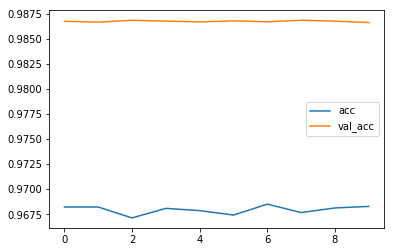

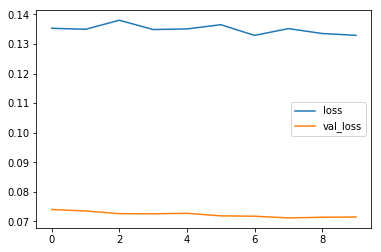

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history)

In [12]:
testGene = testGenerator("../../data/test/sat", num_image=50,target_size=(512,512),as_gray=False)
results = model.predict_generator(testGene, steps=50)
saveResult("../../data/test/predict",results)

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/0_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/1_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/2_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/3_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/4_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-p

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/46_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/47_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/48_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/49_predict.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
